In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv("../datasets/train_radiomics_hipocamp.csv")

X_test = pd.read_csv("../datasets/test_radiomics_hipocamp.csv")

In [3]:
X = df.drop(['Transition'], axis=1)     
y = df['Transition'].to_frame()         

In [4]:
X_numerico = X.select_dtypes(include=[np.number])

X_test = X_test.select_dtypes(include=[np.number])

In [5]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=2022, max_depth=6)
model.fit(X_numerico, y)

DecisionTreeClassifier(max_depth=6, random_state=2022)

In [6]:
import shap as shap

explainer = shap.TreeExplainer(model, X_numerico)
shap_values = explainer(X_numerico, check_additivity=False) 

c:\Users\super\anaconda3\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


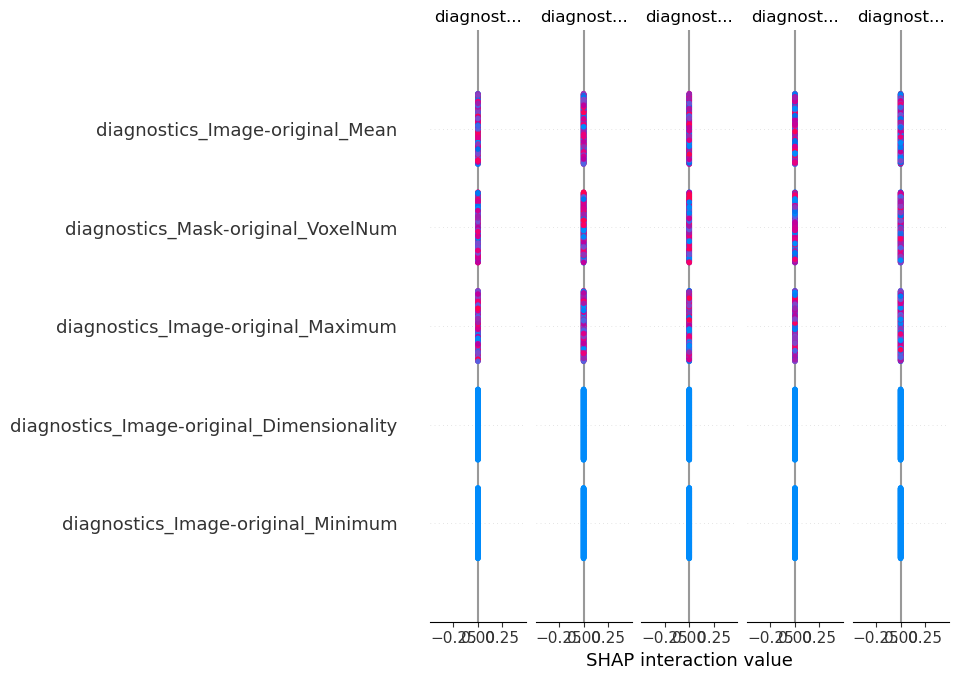

In [7]:
shap.summary_plot(shap_values.values, X_numerico)


In [11]:
import numpy as np

# Aggregate SHAP values across outputs
shap_values_aggregated = np.mean(np.abs(shap_values.values), axis=2)

# Compute feature importance
feature_importance = np.mean(shap_values_aggregated, axis=0)

# Align with feature names
feature_names = X_numerico.columns
assert len(feature_names) == len(feature_importance), "Feature names and importance scores mismatch!"

# Sort features by importance
sorted_features = sorted(zip(feature_names, feature_importance), key=lambda x: x[1], reverse=True)

# Display sorted feature importance
print("Sorted Feature Importances:")
for feature, importance in sorted_features[:20]:  # Show top 20 features
    print(f"{feature}: {importance}")


Sorted Feature Importances:
wavelet-LLL_glrlm_ShortRunEmphasis: 0.1074755176392786
log-sigma-1-0-mm-3D_gldm_SmallDependenceLowGrayLevelEmphasis: 0.03611670356724283
log-sigma-2-0-mm-3D_firstorder_InterquartileRange: 0.035646801396747904
wavelet-LHH_glszm_SmallAreaHighGrayLevelEmphasis: 0.034981816697484736
wavelet-LLH_glszm_HighGrayLevelZoneEmphasis: 0.02891143419836251
Age: 0.027726812523802293
wavelet-LHH_gldm_SmallDependenceLowGrayLevelEmphasis: 0.025470049382200023
wavelet-LLH_firstorder_TotalEnergy: 0.023013385633502522
wavelet-LHH_glcm_MaximumProbability: 0.021927213453098407
log-sigma-2-0-mm-3D_glszm_LargeAreaLowGrayLevelEmphasis: 0.01633073255481028
log-sigma-5-0-mm-3D_glrlm_GrayLevelNonUniformityNormalized: 0.01627092925837172
log-sigma-5-0-mm-3D_glcm_MCC: 0.015299672311055862
log-sigma-3-0-mm-3D_ngtdm_Strength: 0.012421712230264649
log-sigma-5-0-mm-3D_firstorder_Skewness: 0.011914317127915719
lbp-3D-k_firstorder_Skewness: 0.011267650498034519
wavelet-LLL_glcm_DifferenceEntrop

In [12]:
threshold = np.percentile(feature_importance, 90)  # Keep top 10% features
selected_features = [name for name, importance in sorted_features if importance > threshold]

In [13]:
X_numerico = X_numerico[selected_features]

X_test = X_test[selected_features]

In [15]:
model.fit(X_numerico,y)

DecisionTreeClassifier(max_depth=6, random_state=2022)

In [16]:
predictions = model.predict(X_test)
predictions

array(['MCI-AD', 'MCI-MCI', 'CN-MCI', 'CN-CN', 'AD-AD', 'MCI-AD', 'AD-AD',
       'CN-CN', 'AD-AD', 'AD-AD', 'CN-CN', 'CN-MCI', 'CN-CN', 'CN-CN',
       'CN-CN', 'MCI-AD', 'CN-CN', 'MCI-AD', 'MCI-AD', 'MCI-AD',
       'MCI-MCI', 'MCI-AD', 'CN-CN', 'MCI-MCI', 'MCI-MCI', 'CN-MCI',
       'AD-AD', 'CN-CN', 'CN-CN', 'CN-CN', 'CN-CN', 'MCI-MCI', 'CN-CN',
       'MCI-MCI', 'MCI-AD', 'MCI-AD', 'MCI-MCI', 'MCI-MCI', 'CN-CN',
       'CN-CN', 'MCI-MCI', 'CN-CN', 'AD-AD', 'CN-CN', 'CN-CN', 'MCI-AD',
       'MCI-MCI', 'MCI-MCI', 'AD-AD', 'MCI-AD', 'MCI-AD', 'MCI-AD',
       'MCI-MCI', 'MCI-MCI', 'CN-CN', 'AD-AD', 'CN-CN', 'MCI-MCI',
       'MCI-AD', 'AD-AD', 'CN-CN', 'MCI-MCI', 'CN-CN', 'MCI-AD', 'CN-CN',
       'CN-CN', 'CN-CN', 'CN-CN', 'MCI-AD', 'CN-CN', 'MCI-AD', 'MCI-AD',
       'CN-CN', 'MCI-AD', 'MCI-MCI', 'MCI-MCI', 'MCI-AD', 'AD-AD',
       'CN-CN', 'MCI-MCI', 'AD-AD', 'MCI-AD', 'AD-AD', 'CN-CN', 'AD-AD',
       'MCI-MCI', 'AD-AD', 'MCI-AD', 'MCI-MCI', 'CN-CN', 'MCI-MCI',
       'MCI-MCI'

In [17]:
data = pd.DataFrame({
    'RowId': np.arange(1, len(predictions) + 1), 
    'Result': predictions
})

data.to_csv('dt_max6_top10%.csv', index=False)